In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
from imblearn.under_sampling import RandomUnderSampler
import torch
import torch.nn as nn

import h5py

# CHECK THE PATH
os.chdir("/home/d/PycharmProjects/protein_properties")
from src.models import GlycoModel

2024-12-15 15:16:45.605265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734272205.747542   90640 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734272205.782889   90640 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 15:16:46.112936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_negative_test = pd.read_csv('data/OglyPred/Feature_Extraction_O_linked_Testing_Negative_11466_Sites_less.txt',header=None)
df_positive_test = pd.read_csv('data/OglyPred/Feature_Extraction_O_linked_Testing_Positive_375_Sites_less.txt',header=None)
hard_test = pd.read_csv('data/glyco/O/O_test_RR.csv')

Header_name = ["Position","PID","Position_redundant","81 Window sequence","S or T"]

col_of_feature = [i for i in range(1,1025)]

Header_name = Header_name + col_of_feature

df_positive_test.columns = Header_name

df_negative_test.columns = Header_name
df_negative_test['label'] = 0
df_positive_test['label'] = 1

frames_test = [df_positive_test, df_negative_test]

O_linked_testing = pd.concat(frames_test,ignore_index = True)
O_linked_testing_3 = O_linked_testing[O_linked_testing['PID'].isin(hard_test['PID'])]
O_linked_testing_3 = O_linked_testing.merge(hard_test, on=['PID', 'Position'], how='inner')

In [3]:
O_linked_testing

,Position,PID,Position_redundant,81 Window sequence,S or T,1,2,3,4,5,...,1016,1017,1018,1019,1020,1021,1022,1023,1024,label
0,660,Q8N2Q7,660,QKDQLYLHIGLKPRVKEHYRANKVNLWLELVPHLHNLNDISQYTST...,S,0.327869,0.080660,0.222879,0.142154,0.052180,...,0.179476,-0.277779,-0.014718,0.205984,-0.189746,0.077199,0.082022,-0.299386,-0.094365,1
1,2399,P22105,2399,SGLEPDNKYKMNLYGFHGGQRVGPVSAIGVTAAEEETPSPTEPSME...,T,0.327311,0.159786,0.123280,-0.091177,0.493599,...,-0.097531,0.084780,-0.077403,0.488126,-0.007235,-0.449360,0.088786,0.168456,0.157007,1
2,126,O43493,126,AEAKTQKDSSNKSGAEAKTQKGSTSKSGSEAQTTKDSTSKSHPELQ...,S,0.337857,0.267689,0.459043,-0.075335,0.119966,...,0.422891,0.395332,-0.128275,0.310365,0.661715,0.201181,-0.307933,0.299604,0.340042,1
3,3100,P12111,3100,CYLRSQVRATYHGSFSTKKSQPPPPQPARSASSSTINLMVSTEPLA...,S,-0.276647,0.005477,0.229345,0.354421,0.091238,...,0.197130,0.083725,0.021356,0.019329,0.008923,0.346441,-0.004119,0.179007,-0.252509,1
4,847,Q6IEE7,847,VGLRVHFGRDEEDPTYDYPGPSQPGPGGGEDEARGAGPPGSALPAP...,S,0.258675,0.019867,0.265641,0.057011,-0.115738,...,0.091420,-0.052356,0.117375,0.185263,-0.024224,0.135832,-0.131375,-0.099655,0.175931,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11835,576,Q5JRA6,576,SKGMLHEEKPGEQILEGGSESESAQKAAGNQMNDRKIQQESLGSAP...,S,0.082863,0.016339,0.118217,0.059352,-0.157056,...,0.311153,-0.171053,-0.186325,0.077634,-0.035183,0.476564,-0.088527,0.070073,0.025204,0
11836,781,Q8WUM4,781,TPAPRTMPPTKPQPPARPPPPVLPANRAPSATAPSPVGAGTAAPAP...,T,0.143830,0.128729,0.011411,0.221420,-0.069342,...,-0.005958,-0.076819,-0.041807,0.102259,-0.056333,-0.136962,-0.172001,0.103369,0.097399,0
11837,787,Q8WUM4,787,MPPTKPQPPARPPPPVLPANRAPSATAPSPVGAGTAAPAPSQTPGS...,S,0.219440,0.056615,0.278730,0.277934,-0.255328,...,0.085922,0.025087,-0.117150,0.211639,-0.042160,0.093672,-0.083988,0.102665,0.071638,0
11838,684,Q6IEE7,684,DSSTLAGLEPGTTPFKVVSPLTEAVLGETLLTVTEEKVSITQLQAQ...,T,0.395778,0.111214,0.097905,-0.100399,0.224180,...,0.140031,-0.062952,-0.376390,0.132737,-0.030343,-0.195613,0.117807,-0.063602,-0.396030,0


# Undersampled Independent Test Dataset

In [4]:
seed = 370381
#seed = 4215
print("Seed    :",seed)
rus = RandomUnderSampler(random_state = seed)
O_linked_testing.columns = O_linked_testing.columns.astype(str)
O_linked_testing, y_independent = rus.fit_resample(O_linked_testing, O_linked_testing['label'])

Seed    : 370381


In [5]:
O_linked_testing.reset_index(drop=True, inplace=True)
y_test_full = np.array(O_linked_testing['label'])
y_test_full[y_test_full == 2] = 1 
y_independent = y_test_full

In [6]:
O_linked_testing.columns

Index(['Position', 'PID', 'Position_redundant', '81 Window sequence', 'S or T',
       '1', '2', '3', '4', '5',
       ...
       '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024',
       'label'],
      dtype='object', length=1030)

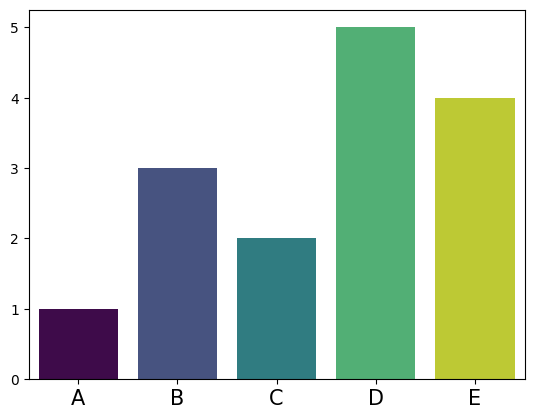

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import pandas as pd
from src.utils import mean_confidence_interval
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
plt.rcParams.update({
    "font.size": 12,  
    # Base font size
    "axes.titlesize": 16,      # Axis title font size
    "axes.labelsize": 15,      # Axis label font size
    "xtick.labelsize": 15,     # X-axis tick label font size
    "ytick.labelsize": 10      # Y-axis tick label font size
})
n_colors = 5
viridis = plt.cm.viridis
colors = [to_hex(viridis(i)) for i in np.linspace(0.0, 0.93, n_colors)]

# Apply the palette
custom_palette = sns.color_palette(colors)

# Example plot
sns.set_palette(custom_palette)
sns.barplot(x=["A", "B", "C", "D", "E"], y=[1, 3, 2, 5, 4])
plt.show()

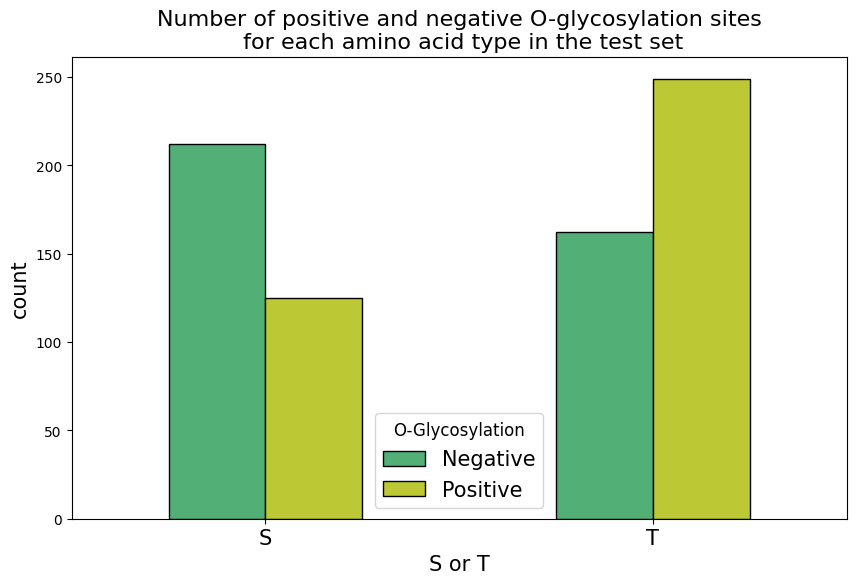

In [8]:
# plot the number of postive and negative samples for each amino acid type

plot_df = O_linked_testing[['S or T','label']]

# plot the number of postive and negative samples for each amino acid type in a barplot. 
# use the custom palette defined above 2 last colors 
plt.figure(figsize=(10,6))
sns.countplot(x='S or T', hue='label', data=plot_df, palette=custom_palette[-2:], edgecolor='black', width=0.5) 
plt.title('Number of positive and negative O-glycosylation sites\n for each amino acid type in the test set')
plt.legend(title='O-Glycosylation', loc='best', labels=['Negative', 'Positive'], fontsize=15)
plt.savefig('results/plots/O_linked_test_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
df_Test_array = O_linked_testing.drop(["Position","PID","Position_redundant","81 Window sequence","S or T", 'label'],axis=1)
df_Test_array = np.array(df_Test_array)

X_test_full = df_Test_array
X_independent = X_test_full

In [10]:
undersampled_idx, _ = rus.fit_resample(np.arange(len(y_test_full)).reshape(-1,1),y_test_full)

# Load the Trained Model

In [11]:
model = tf.keras.models.load_model("checkpoints/Pakhrin_O_linked_glyco.h5i")
model.summary()

I0000 00:00:1734272216.694734   90640 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4482 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,420 (2.53 MB)

 Trainable params: 664,418 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Predict whether the site is O-linked Glycosylated or Not

In [12]:
Y_pred = model.predict(X_independent)
Y_pred_theirs = Y_pred
Y_pred = (Y_pred > 0.5)

y_pred = [np.argmax(y, axis=None, out=None) for y in Y_pred]
y_pred = np.array(y_pred)
y_pred_theirs = y_pred
print("Independent Testing Matthews Correlation: ",matthews_corrcoef(y_independent, y_pred))
print()
print()
print("Confusion Matrix : \n",confusion_matrix(y_independent, y_pred))
print()
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()
cm = confusion_matrix(y_independent, y_pred)

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

mcc = matthews_corrcoef(y_independent, y_pred)



Sensitivity = TP/(TP+FN)

Specificity = TN/(TN+FP)

print()
print("Sensitivity:   ",Sensitivity,"\t","Specificity:   ",Specificity)
print()

fpr, tpr, _ = roc_curve(y_independent, y_pred)

roc_auc_test = auc(fpr,tpr)

pre = TP / (TP + FP)
print()
print("Precision :  ",pre)
print()
print()

print("Area Under Curve:   ",roc_auc_test)
print(classification_report(y_independent, y_pred))
y_independent_theirs = y_independent

I0000 00:00:1734272217.810657   90808 service.cc:148] XLA service 0x7efb10004df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734272217.810819   90808 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-12-15 15:16:57.827114: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734272217.876443   90808 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/24 ━━━━━━━━━━━━━━━━━━━━ 9s 434ms/step

2024-12-15 15:16:58.101533: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1734272218.165168   90808 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Independent Testing Matthews Correlation:  0.6126696948450258


Confusion Matrix : 
 [[308  66]
 [ 79 295]]


Accuracy on test set:    0.8061497326203209


Sensitivity:    0.7887700534759359 	 Specificity:    0.8235294117647058


Precision :   0.817174515235457


Area Under Curve:    0.8061497326203209
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       374
           1       0.82      0.79      0.80       374

    accuracy                           0.81       748
   macro avg       0.81      0.81      0.81       748
weighted avg       0.81      0.81      0.81       748



### Our Model

In [13]:
our_model = GlycoModel.load_from_checkpoint("tb_logs/glyco_O_cv_1/version_0/checkpoints/epoch=6-step=3500.ckpt")
print(our_model)
# disable randomness, dropout, etc...
our_model.eval()

# load esm embeddings for our model

with h5py.File("data/glyco/glyco_esm_embeddings.h5", "r") as f:
    X = np.empty((X_independent.shape[0], 1280), dtype=np.float32)
    for i, (pid, pos) in enumerate(zip(O_linked_testing["PID"], O_linked_testing["Position"])):
        try:
            X[i] = f[pid][()][pos - 1]
        except IndexError:
            print(f'Couldnt find {pid} at position {pos}')
        except KeyError:
            print(f'Couldnt find {pid}')
#X = X[rus.sample_indices_]
X_independent = np.concatenate([X_independent, X], axis=1)
X_tensor = torch.tensor(X_independent, dtype=torch.float32).to('cuda')
# predict with the model
y_hat = our_model(X_tensor)
Y_pred_ours_oversampling = y_hat.cpu().detach().numpy()

GlycoModel(
  (model): Sequential(
    (0): Linear(in_features=2304, out_features=46, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=46, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
)


In [14]:
y_hat_s = y_hat

In [15]:
if y_hat.shape[1] == 1:
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = y_hat > 0.5
    y_hat = y_hat.astype(int).flatten()
else: 
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = np.argmax(y_hat, axis=1)
    y_hat[y_hat == 2] = 1

In [16]:
y_pred_our_oversampling = y_hat
y_pred = np.array(y_hat)
print("Independent Testing Matthews Correlation: ",matthews_corrcoef(y_independent, y_pred))
print()
print()
print("Confusion Matrix : \n",confusion_matrix(y_independent, y_pred))
print()
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()
cm = confusion_matrix(y_independent, y_pred)

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

mcc = matthews_corrcoef(y_independent, y_pred)



Sensitivity = TP/(TP+FN)

Specificity = TN/(TN+FP)

print()
print("Sensitivity:   ",Sensitivity,"\t","Specificity:   ",Specificity)
print()

fpr, tpr, _ = roc_curve(y_independent, y_pred)

roc_auc_test = auc(fpr,tpr)

pre = TP / (TP + FP)
print()
print("Precision :  ",pre)
print()
print()

print("Area Under Curve:   ",roc_auc_test)
print(classification_report(y_independent, y_pred))

Independent Testing Matthews Correlation:  0.5976534569752873


Confusion Matrix : 
 [[348  26]
 [134 240]]


Accuracy on test set:    0.786096256684492


Sensitivity:    0.6417112299465241 	 Specificity:    0.93048128342246


Precision :   0.9022556390977443


Area Under Curve:    0.7860962566844919
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       374
           1       0.90      0.64      0.75       374

    accuracy                           0.79       748
   macro avg       0.81      0.79      0.78       748
weighted avg       0.81      0.79      0.78       748



Area Under Curve:    0.7936288088642659
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       361
           1       0.80      0.79      0.79       361

    accuracy                           0.79       722
   macro avg       0.79      0.79      0.79       722
weighted avg       0.79      0.79      0.79       722

### Our Model no oversampling

In [17]:
our_model = GlycoModel.load_from_checkpoint("tb_logs/glyco_O_cv_4/version_1/checkpoints/epoch=27-step=5348.ckpt")
our_model.eval()
y_hat = our_model(X_tensor)
Y_pred_ours_nooversampling = y_hat.cpu().detach().numpy()
if y_hat.shape[1] == 1:
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = y_hat > 0.5
    y_hat = y_hat.astype(int).flatten()
else: 
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = np.argmax(y_hat, axis=1)
    y_hat[y_hat == 2] = 1

In [18]:
y_pred_our_nooversampling = y_hat
y_pred = np.array(y_hat)
print("Independent Testing Matthews Correlation: ",matthews_corrcoef(y_independent, y_pred))
print()
print()
print("Confusion Matrix : \n",confusion_matrix(y_independent, y_pred))
print()
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()
cm = confusion_matrix(y_independent, y_pred)

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

mcc = matthews_corrcoef(y_independent, y_pred)



Sensitivity = TP/(TP+FN)

Specificity = TN/(TN+FP)

print()
print("Sensitivity:   ",Sensitivity,"\t","Specificity:   ",Specificity)
print()

fpr, tpr, _ = roc_curve(y_independent, y_pred)

roc_auc_test = auc(fpr,tpr)

pre = TP / (TP + FP)
print()
print("Precision :  ",pre)
print()
print()

print("Area Under Curve:   ",roc_auc_test)
print(classification_report(y_independent, y_pred))

Independent Testing Matthews Correlation:  0.6273764344284781


Confusion Matrix : 
 [[339  35]
 [109 265]]


Accuracy on test set:    0.8074866310160428


Sensitivity:    0.7085561497326203 	 Specificity:    0.9064171122994652


Precision :   0.8833333333333333


Area Under Curve:    0.8074866310160427
              precision    recall  f1-score   support

           0       0.76      0.91      0.82       374
           1       0.88      0.71      0.79       374

    accuracy                           0.81       748
   macro avg       0.82      0.81      0.81       748
weighted avg       0.82      0.81      0.81       748



## 3 class model

In [19]:
our_model = GlycoModel.load_from_checkpoint("tb_logs/glyco_3class_cv_1/version_0/checkpoints/epoch=28-step=9222.ckpt")
our_model.eval()
y_hat = our_model(X_tensor)
Y_pred_ours_3class = y_hat.cpu().detach().numpy()
if y_hat.shape[1] == 1:
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = y_hat > 0.5
    y_hat = y_hat.astype(int).flatten()
else: 
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = np.argmax(y_hat, axis=1)
    y_hat[y_hat == 2] = 1

In [20]:

y_pred_our_3class = y_hat
y_pred = np.array(y_hat)
print("Independent Testing Matthews Correlation: ",matthews_corrcoef(y_independent, y_pred))
print()
print()
print("Confusion Matrix : \n",confusion_matrix(y_independent, y_pred))
print()
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()
cm = confusion_matrix(y_independent, y_pred)

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

mcc = matthews_corrcoef(y_independent, y_pred)



Sensitivity = TP/(TP+FN)

Specificity = TN/(TN+FP)

print()
print("Sensitivity:   ",Sensitivity,"\t","Specificity:   ",Specificity)
print()

fpr, tpr, _ = roc_curve(y_independent, y_pred)

roc_auc_test = auc(fpr,tpr)

pre = TP / (TP + FP)
print()
print("Precision :  ",pre)
print()
print()

print("Area Under Curve:   ",roc_auc_test)
print(classification_report(y_independent, y_pred))
y_independent_ours_3class = y_independent

Independent Testing Matthews Correlation:  0.6153180017051055


Confusion Matrix : 
 [[283  91]
 [ 54 320]]


Accuracy on test set:    0.8061497326203209


Sensitivity:    0.8556149732620321 	 Specificity:    0.7566844919786097


Precision :   0.7785888077858881


Area Under Curve:    0.8061497326203209
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       374
           1       0.78      0.86      0.82       374

    accuracy                           0.81       748
   macro avg       0.81      0.81      0.81       748
weighted avg       0.81      0.81      0.81       748



### VespaG baseline 

In [21]:
from src.utils import read_vespag
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import h5py
from enum import Enum
from imblearn.under_sampling import RandomUnderSampler
GEMME_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"
glyco_class = 'O'
glyco_sites = pd.read_csv('data/glyco/O/O_train_RR.csv')
glyco_sites_val = pd.read_csv('data/glyco/O/O_val_RR.csv')

glyco_sites['split'] = 'train'
glyco_sites_val['split'] = 'train'

glyco_sites_test = O_linked_testing[['PID', 'Position', 'label']]
glyco_sites_test['split'] = 'test'  
glyco_sites = pd.concat([glyco_sites, glyco_sites_val, glyco_sites_test])

#glyco_sites = glyco_sites[glyco_sites["AA"] != 'N']
#glyco_sites, labels = ros.fit_resample(glyco_sites, labels)
glyco_sites.reset_index(drop=True, inplace=True)
print(glyco_sites)


vespa_scores = []

pids = []
with h5py.File("data/glyco/glyco_vespag_scores.h5", "r") as vesp:
    for pid, pos in zip(glyco_sites["PID"].values, glyco_sites["Position"].values):
        try:
            vespa_score = vesp[pid.replace('-', '_')][()][pos - 1]
        except KeyError:
            vespa_score = np.zeros(20)
            idx = glyco_sites[(glyco_sites["PID"] == pid) & (glyco_sites["Position"] == pos)].index
            glyco_sites = glyco_sites.drop(idx)
            continue
        except IndexError:
            vespa_score = np.zeros(20)
            idx = glyco_sites[(glyco_sites["PID"] == pid) & (glyco_sites["Position"] == pos)].index
            glyco_sites = glyco_sites.drop(idx)
            continue
        vespa_scores.append(vespa_score)
print(len(vespa_scores))
vespa_scores = np.array(vespa_scores)
glyco_sites.reset_index(drop=True, inplace=True)

train_idx = glyco_sites[glyco_sites["split"] == 'train'].index

test_idx = glyco_sites[glyco_sites["split"] == 'test'].index

X_train = vespa_scores[train_idx]
y_train = glyco_sites["label"].values[train_idx]
ros = RandomUnderSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_test = vespa_scores[test_idx]
y_test = glyco_sites["label"].values[test_idx]

print(X_train.shape, X_test.shape)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)
Y_pred_vespaG = rf.predict_proba(X_test)
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score, matthews_corrcoef
print(roc_auc_score(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred_vespaG = y_pred
y_independent_vespaG = y_test

          PID  Position  label   AA  split
0      Q8WXI7      4060      1    S  train
1      P15514        52      1    T  train
2      O00461       270      1    T  train
3      Q86VZ4       303      1    T  train
4      P04275      1468      1    T  train
...       ...       ...    ...  ...    ...
89025  Q12770       571      1  NaN   test
89026  O43493       137      1  NaN   test
89027  P22105      3923      1  NaN   test
89028  Q9Y6N7       661      1  NaN   test
89029  P01024       111      1  NaN   test

[89030 rows x 5 columns]


/tmp/ipykernel_90640/618067919.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glyco_sites_test['split'] = 'test'


83759
(8204, 20) (711, 20)
              precision    recall  f1-score   support

           0       0.66      0.75      0.71       338
           1       0.74      0.66      0.70       373

    accuracy                           0.70       711
   macro avg       0.70      0.70      0.70       711
weighted avg       0.71      0.70      0.70       711

0.7041578755334169
0.40895852811477884
[[254  84]
 [128 245]]


### Plot it like it's hot

In [22]:
def calculate_metrics_bootstrap(y_true, y_pred):
    f1_scores = []
    mcc_scores = []

    for i in range(1000):
        # randomly sample with replacement
        idx = np.random.choice(range(len(y_true)), len(y_true), replace=True)
        y_true_sampled = y_true[idx]
        y_pred_sampled = y_pred[idx]
        f1_scores.append(f1_score(y_true_sampled, y_pred_sampled, average="macro"))
        mcc_scores.append(matthews_corrcoef(y_true_sampled, y_pred_sampled))
        fpr, tpr, thresholds = roc_curve(y_true_sampled, y_pred_sampled)
        
    return f1_scores, mcc_scores

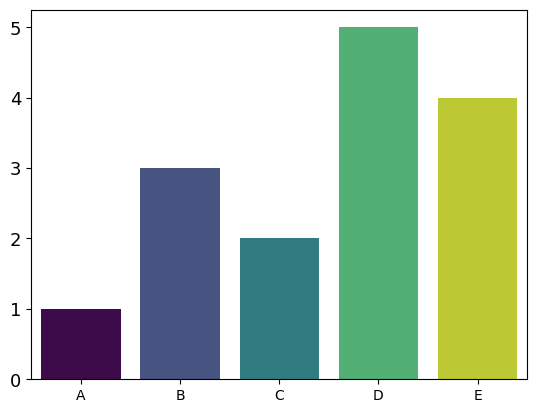

In [23]:
# first plot a bar chart for F1 MCC for all models
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import pandas as pd
from src.utils import mean_confidence_interval
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
plt.rcParams.update({
    "font.size": 12,  
    # Base font size
    "axes.titlesize": 16,      # Axis title font size
    "axes.labelsize": 15,      # Axis label font size
    "xtick.labelsize": 10,     # X-axis tick label font size
    "ytick.labelsize": 13      # Y-axis tick label font size
})
n_colors = 5
viridis = plt.cm.viridis
colors = [to_hex(viridis(i)) for i in np.linspace(0, 0.93, n_colors)]

# Apply the palette
custom_palette = sns.color_palette(colors)

# Example plot
sns.set_palette(custom_palette)
sns.barplot(x=["A", "B", "C", "D", "E"], y=[1, 3, 2, 5, 4])
plt.show()

In [29]:
def random_baseline(y_true):
    return np.random.choice([0, 1], len(y_true))

In [30]:
models = ['Pakhrin et al. 2023', 'Ours (oversampled)', 'Ours (no oversampling)', 'Ours (3class)', 'VespaG Basline']
# calculate F1 MCC for all models
def calc_f1_mcc(y_true, y_pred):
    f1s, mccs = calculate_metrics_bootstrap(y_true, y_pred)
    _, f1_ci = mean_confidence_interval(f1s)
    _, mcc_ci = mean_confidence_interval(mccs)
    f1 = f1_score(y_true, y_pred, average="macro")
    mcc = matthews_corrcoef(y_true, y_pred)
    return f1, f1_ci, mcc, mcc_ci
their_f1, their_f1_ci, their_mcc, their_mcc_ci = calc_f1_mcc(y_independent_theirs, y_pred_theirs)
ours_oversamp_f1, ours_oversamp_f1_ci, ours_oversamp_mcc, ours_oversamp_mcc_ci = calc_f1_mcc(y_independent, y_pred_our_oversampling)
ours_nooversamp_f1, ours_nooversamp_f1_ci, ours_nooversamp_mcc, ours_nooversamp_mcc_ci = calc_f1_mcc(y_independent, y_pred_our_nooversampling)
ours_3class_f1, ours_3class_f1_ci, ours_3class_mcc, ours_3class_mcc_ci = calc_f1_mcc(y_independent_ours_3class, y_pred_our_3class)
vespag_f1, vespag_f1_ci, vespag_mcc, vespag_mcc_ci = calc_f1_mcc(y_independent_vespaG, y_pred_vespaG)
random_f1, random_f1_ci, random_mcc, random_mcc_ci = calc_f1_mcc(y_independent, random_baseline(y_independent))

In [31]:
print(f"Their model: F1 {their_f1:.3f} ({their_f1_ci:.3f}), MCC {their_mcc:.3f} ({their_mcc_ci:.3f})")
print(f"Our model (oversampled): F1 {ours_oversamp_f1:.3f} ({ours_oversamp_f1_ci:.3f}), MCC {ours_oversamp_mcc:.3f} ({ours_oversamp_mcc_ci:.3f})")
print(f"Our model (no oversampling): F1 {ours_nooversamp_f1:.3f} ({ours_nooversamp_f1_ci:.3f}), MCC {ours_nooversamp_mcc:.3f} ({ours_nooversamp_mcc_ci:.3f})")
print(f"Our model (3class): F1 {ours_3class_f1:.3f} ({ours_3class_f1_ci:.3f}), MCC {ours_3class_mcc:.3f} ({ours_3class_mcc_ci:.3f})")
print(f"VespaG Baseline: F1 {vespag_f1:.3f} ({vespag_f1_ci:.3f}), MCC {vespag_mcc:.3f} ({vespag_mcc_ci:.3f})")
print(f"Random Baseline: F1 {random_f1:.3f} ({random_f1_ci:.3f}), MCC {random_mcc:.3f} ({random_mcc_ci:.3f})")

Their model: F1 0.806 (0.001), MCC 0.613 (0.002)
Our model (oversampled): F1 0.782 (0.001), MCC 0.598 (0.002)
Our model (no oversampling): F1 0.806 (0.001), MCC 0.627 (0.002)
Our model (3class): F1 0.806 (0.001), MCC 0.615 (0.002)
VespaG Baseline: F1 0.702 (0.001), MCC 0.409 (0.002)
Random Baseline: F1 0.487 (0.001), MCC -0.027 (0.002)


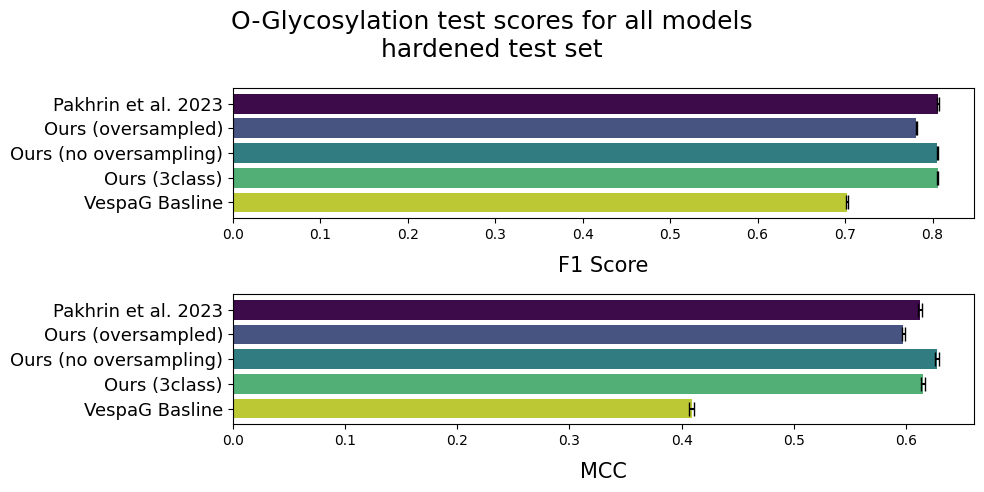

In [ ]:


f1s = [their_f1, ours_oversamp_f1, ours_nooversamp_f1, ours_3class_f1, vespag_f1]
mccs = [their_mcc, ours_oversamp_mcc, ours_nooversamp_mcc, ours_3class_mcc, vespag_mcc]
df = pd.DataFrame({'Model': models, 'F1': f1s, 'MCC': mccs})
# y axis should be the metrics comparing all models against each other
# bars should be horizontal
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig.suptitle('O-Glycosylation test scores for all models\nhardened test set', fontsize=18)
sns.barplot(x='F1', y='Model', data=df, ax=ax[0])
ax[0].errorbar(f1s, 
               models, 
               xerr=[their_f1_ci, ours_oversamp_f1_ci, ours_nooversamp_f1_ci, ours_3class_f1_ci, vespag_f1_ci], 
               fmt='none', 
               color='black', 
               capsize=5)
#space between the two plots
plt.subplots_adjust(hspace=0.5)
sns.barplot(x='MCC', y='Model', data=df, ax=ax[1])
ax[1].errorbar(mccs, 
               models, 
               xerr=[their_mcc_ci, ours_oversamp_mcc_ci, ours_nooversamp_mcc_ci, ours_3class_mcc_ci, vespag_mcc_ci], 
               fmt='none', 
               color='black', 
               capsize=5)

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_xlabel('F1 Score', labelpad=10)
ax[1].set_xlabel('MCC', labelpad=10)
plt.tight_layout()
plt.savefig('results/plots/O_glyco_f1_mcc.png', dpi=300, bbox_inches = "tight")
plt.show()




<function matplotlib.pyplot.show(close=None, block=None)>

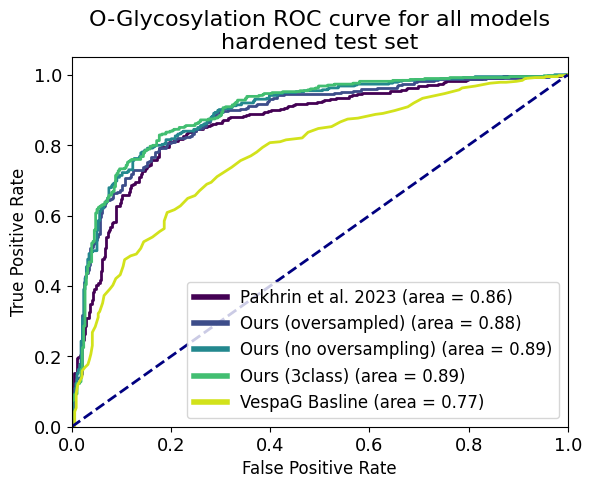

In [25]:
# next roc curve for all models
plt.rcParams.update({
    "font.size": 12,           # Base font size
    "axes.titlesize": 16,      # Axis title font size
    "axes.labelsize": 15,      # Axis label font size
    "xtick.labelsize": 13,     # X-axis tick label font size
    "ytick.labelsize": 13      # Y-axis tick label font size
})
fpr_theirs, tpr_theirs, _ = roc_curve(y_independent_theirs, Y_pred_theirs[:,1])
roc_auc_theirs = auc(fpr_theirs, tpr_theirs)
fpr_ours_oversamp, tpr_ours_oversamp, _ = roc_curve(y_independent, Y_pred_ours_oversampling)
roc_auc_ours_oversamp = auc(fpr_ours_oversamp, tpr_ours_oversamp)
fpr_ours_nooversamp, tpr_ours_nooversamp, _ = roc_curve(y_independent, Y_pred_ours_nooversampling)
roc_auc_ours_nooversamp = auc(fpr_ours_nooversamp, tpr_ours_nooversamp)
fpr_ours_3class, tpr_ours_3class, _ = roc_curve(y_independent_ours_3class, Y_pred_ours_3class[:,2])
roc_auc_ours_3class = auc(fpr_ours_3class, tpr_ours_3class)
fpr_vespag, tpr_vespag, _ = roc_curve(y_independent_vespaG, Y_pred_vespaG[:,1])
roc_auc_vespag = auc(fpr_vespag, tpr_vespag)
plt.figure()
lw = 2
# use the same colors as the bar plot from the seaborn palette
plt.plot(fpr_theirs, tpr_theirs, color=colors[0],
         lw=lw, label='Pakhrin et al. 2023 (area = %0.2f)' % roc_auc_theirs)
plt.plot(fpr_ours_oversamp, tpr_ours_oversamp, color=colors[1],
            lw=lw, label='Ours (oversampled) (area = %0.2f)' % roc_auc_ours_oversamp)
plt.plot(fpr_ours_nooversamp, tpr_ours_nooversamp, color=colors[2],
            lw=lw, label='Ours (no oversampling) (area = %0.2f)' % roc_auc_ours_nooversamp)
plt.plot(fpr_ours_3class, tpr_ours_3class, color=colors[3],
            lw=lw, label='Ours (3class) (area = %0.2f)' % roc_auc_ours_3class)
plt.plot(fpr_vespag, tpr_vespag, color=colors[4],
            lw=lw, label='VespaG Basline (area = %0.2f)' % roc_auc_vespag)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('O-Glycosylation ROC curve for all models\nhardened test set')
legend = plt.legend(markerfirst=True, loc="lower right", fontsize=12, )
for line in legend.get_lines():
    line.set_linewidth(4) 
plt.savefig('results/plots/O_glyco_roc.png', dpi=300, bbox_inches = "tight")
plt.show


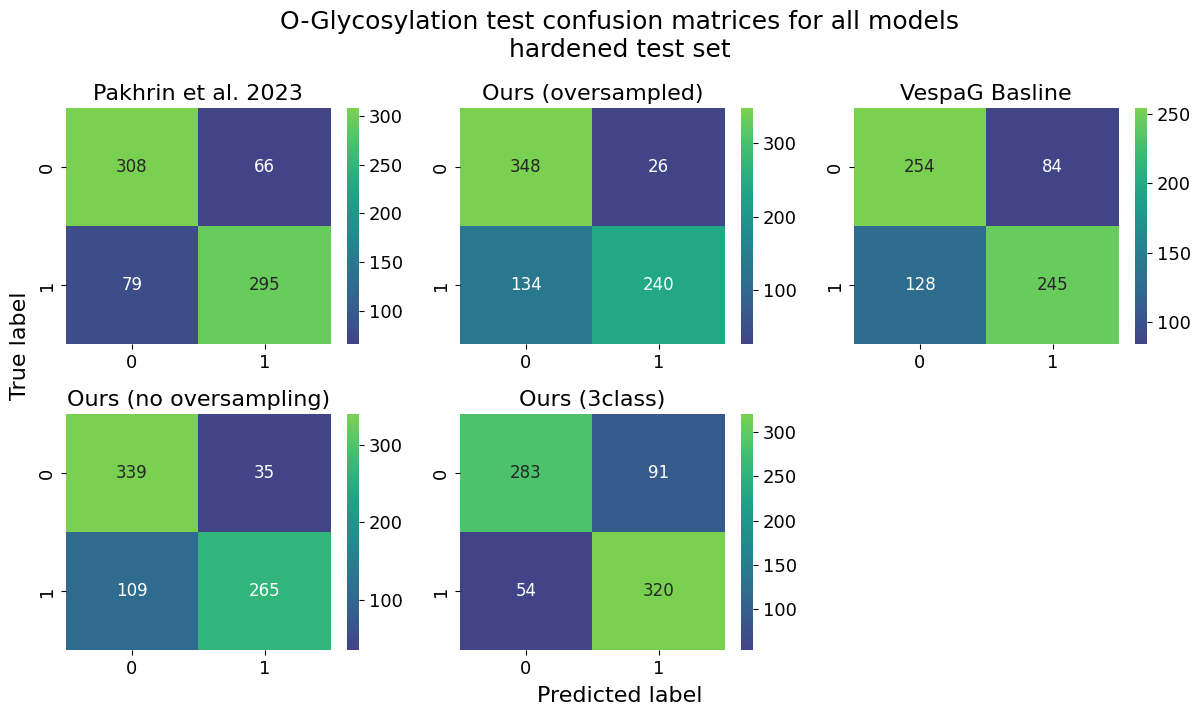

In [26]:
# confusion matrix for all models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Customize the Viridis colormap (e.g., use only the first half of the colors)
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", viridis(np.linspace(0.2, 0.8, 256)))

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('O-Glycosylation test confusion matrices for all models\nhardened test set', fontsize=18)

sns.heatmap(confusion_matrix(y_independent, y_pred_theirs), annot=True, fmt='d', ax=ax[0, 0], cmap=custom_cmap)
ax[0, 0].set_title('Pakhrin et al. 2023')
sns.heatmap(confusion_matrix(y_independent, y_pred_our_oversampling), annot=True, fmt='d', ax=ax[0, 1], cmap=custom_cmap)
ax[0, 1].set_title('Ours (oversampled)')
sns.heatmap(confusion_matrix(y_independent, y_pred_our_nooversampling), annot=True, fmt='d', ax=ax[1, 0], cmap=custom_cmap)
ax[1, 0].set_title('Ours (no oversampling)')
sns.heatmap(confusion_matrix(y_independent_ours_3class, y_pred_our_3class), annot=True, fmt='d', ax=ax[1, 1], cmap=custom_cmap)
ax[1, 1].set_title('Ours (3class)')
sns.heatmap(confusion_matrix(y_independent_vespaG, y_pred_vespaG), annot=True, fmt='d', ax=ax[0, 2], cmap=custom_cmap)
ax[0, 2].set_title('VespaG Basline')
fig.delaxes(ax[1,2])

plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Increase the value to increase the space
plt.tight_layout()
fig.text(0.5, 0.00, 'Predicted label', ha='center', va='center', fontsize=16)
fig.text(0.00, 0.5, 'True label', ha='center', va='center', rotation='vertical', fontsize=16)
plt.savefig('results/plots/O_glyco_confusion_matrices.png', dpi=300, bbox_inches = "tight")
plt.show()

# Without Undersampling the independent Test Dataset

In [27]:
model_without_undersampling = tf.keras.models.load_model("Without_Undersampling_Prot_T5_my_model_O_linked_Glycosylation361035Prot_T5_Subash_Salman_Neha.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'Without_Undersampling_Prot_T5_my_model_O_linked_Glycosylation361035Prot_T5_Subash_Salman_Neha.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
Y_pred = model.predict(X_independent)
Y_pred = (Y_pred > 0.5)
y_pred = [np.argmax(y, axis=None, out=None) for y in Y_pred]
y_pred = np.array(y_pred)
print("Independent Testing Matthews Correlation: ",matthews_corrcoef(y_independent, y_pred))
print()
print()
print("Confusion Matrix : \n",confusion_matrix(y_independent, y_pred))
print()
print()
print("Accuracy on test set:   ",accuracy_score(y_independent, y_pred))
print()
cm = confusion_matrix(y_independent, y_pred)

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

mcc = matthews_corrcoef(y_independent, y_pred)



Sensitivity = TP/(TP+FN)

Specificity = TN/(TN+FP)

print()
print("Sensitivity:   ",Sensitivity,"\t","Specificity:   ",Specificity)
print()

fpr, tpr, _ = roc_curve(y_independent, y_pred)

roc_auc_test = auc(fpr,tpr)

pre = TP / (TP + FP)
print()
print("Precision :  ",pre)
print()
print()

print("Area Under Curve:   ",roc_auc_test)

# Thank You